In [ ]:
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torch import optim

from skimage import io

import torch.nn.functional as F
from torchsummary import summary
torch.__version__

'1.8.1+cu101'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CODEDIR = "./drive/MyDrive/codes/"
CODEDIR

'./drive/MyDrive/codes/'

In [ ]:
!ls "./drive/MyDrive/codes/"

hello.py		  load_dataset.sh     vae_celeba_e15.pt
image_captioning.pth.tar  test_images	      vae_celeba_e30.pt
kaggle.json		  unet_model.pth.tar  vae_celeba_e50.pt


In [ ]:
!mkdir -p ~/.kaggle
!cp ./drive/MyDrive/codes/kaggle.json ~/.kaggle/

In [ ]:
import kaggle

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:12<00:00, 112MB/s]
100% 1.33G/1.33G [00:13<00:00, 109MB/s]


In [ ]:
!unzip celeba-dataset.zip

In [ ]:
available_device= "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(available_device)
print(device)

cuda


In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Loading CelebA dataset

In [ ]:
import pandas as pd
attr_celeba = pd.read_csv('list_attr_celeba.csv')
attr_celeba.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
attr_celeba.iloc[14, 16:]

Eyeglasses             -1
Goatee                 -1
Gray_Hair              -1
Heavy_Makeup           -1
High_Cheekbones        -1
Male                    1
Mouth_Slightly_Open    -1
Mustache               -1
Narrow_Eyes             1
No_Beard                1
Oval_Face              -1
Pale_Skin              -1
Pointy_Nose            -1
Receding_Hairline      -1
Rosy_Cheeks            -1
Sideburns              -1
Smiling                -1
Straight_Hair           1
Wavy_Hair              -1
Wearing_Earrings       -1
Wearing_Hat            -1
Wearing_Lipstick       -1
Wearing_Necklace       -1
Wearing_Necktie         1
Young                  -1
Name: 14, dtype: object

In [ ]:
# check values:
smile = attr_celeba.loc[attr_celeba["Eyeglasses"]==1]
smile.shape

(13193, 41)

In [ ]:
!ls

celeba-dataset.zip  list_attr_celeba.csv     list_landmarks_align_celeba.csv
drive		    list_bbox_celeba.csv     sample_data
img_align_celeba    list_eval_partition.csv


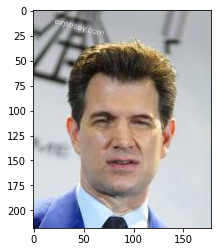

In [ ]:
root_dir = "./img_align_celeba/img_align_celeba/"
img_path = root_dir + attr_celeba.iloc[14, 0]
# image
image = io.imread(img_path)
plt.imshow(image)

In [ ]:
plt.imshow

In [ ]:
torch.tensor(attr_celeba.iloc[1, 1:])

tensor([-1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
        -1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        -1, -1, -1,  1])

In [ ]:
attr_celeba.shape

(202599, 41)

### Dataset

In [ ]:
class CelebA(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        self.attr_frame =  pd.read_csv(csv_file, low_memory=False)
    
    def __len__(self):
        return len(self.attr_frame)

    def __getitem__(self, index):
        attributes = self.attr_frame.iloc[index, 1:]
        img_name = self.attr_frame.iloc[index, 0]
        img_path = os.path.join(self.root + "/" + img_name)
        image = io.imread(img_path)

        attr_tensor = torch.tensor(attributes)

        if self.transform:
            image = self.transform(image)
            
        return (image, attr_tensor)

In [ ]:
csv_file = "list_attr_celeba.csv"
root_dir = "img_align_celeba/img_align_celeba"

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop((128, 128)),
            transforms.ToTensor(),
])

celebA_set = CelebA(csv_file, root_dir, transform)

In [ ]:
train_size = int(len(celebA_set) * 0.9)
test_size = len(celebA_set) - train_size 
print(train_size, test_size)

182339 20260


In [ ]:
train_set, test_set = random_split(celebA_set, 
                                   [train_size, test_size])

### Dataloader

In [ ]:
batch_size = 128
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                        shuffle=True)
print("Data loaded")

Data loaded


In [ ]:
def get_mean_std(loader):
    # Var[x] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0, 0 ,0
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2) ** 0.5
    return mean, std

mean, std = get_mean_std(train_loader)
print(mean)
print(std)

tensor([0.5062, 0.4255, 0.3828])
tensor([0.3106, 0.2903, 0.2896])


In [ ]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 3, 128, 128])
torch.Size([128, 40])


## Show the batch

In [ ]:
def show_grid_tensor(grid_im, label, feature_idx, n, c=None):
    fig = plt.figure(figsize=(15,15))
    for i in range(n):
        ax = plt.subplot(8, 8, i+1)
        plt.imshow(grid_im[i], cmap=c)
        # plt.imshow
        plt.axis("off")
        ax.set_title(f"has feature {label[i][feature_idx]}")
    return plt

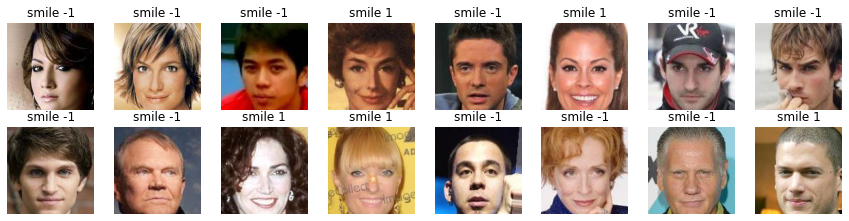

In [ ]:
x_reverse = x.permute(0, 2, 3, 1)
ax1 = show_grid_tensor(x_reverse, y, 31, 16)
ax1.show()

## Prepare the model architecture

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    
    def forward(self, x):
        x = x.view(self.shape)
        return x

class Trim(nn.Module):
    def __init__(self, *args):
        super(Trim, self).__init__()
    
    def forward(self, x):
        return x[:, :, :128, :128]

In [ ]:
class VAE_CELEB(nn.Module):
    def __init__(self, in_channels=1, encoding_dims=2, batch_size=64):
        super(VAE_CELEB, self,).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )

        self.z_mean = nn.Linear(4096, encoding_dims)
        self.z_log_var = nn.Linear(4096, encoding_dims)

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dims, 4096),
            Reshape(-1, 64, 8, 8),
            #
            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
            #
            Trim(),  # 3x129x129 -> 3x128x128
            nn.Sigmoid()
        )

    def reparameterize(self, x, z_mu, z_log_var):
        # z = mu + x * var
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def encoding_fn(self, x):
        x =  self.encoder(x)

        z_mu = self.z_mean(x)
        z_log_var = self.z_log_var(x)    
        # get z using mean and var
        encoded = self.reparameterize(x, z_mu, z_log_var)
        return encoded

    def forward(self, x):
        x =  self.encoder(x)

        z_mu = self.z_mean(x)
        z_log_var = self.z_log_var(x)
            
        # get z using mean and var
        encoded = self.reparameterize(x, z_mu, z_log_var)

        decoded = self.decoder(encoded)

        return encoded, z_mu , z_log_var, decoded

### Initialize the model 

In [ ]:
model = VAE_CELEB(in_channels=3, 
                  encoding_dims=200,
                  batch_size=batch_size).to(device)

In [ ]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
         Dropout2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         LeakyReLU-7           [-1, 64, 32, 32]               0
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          36,864
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        LeakyReLU-11           [-1, 64, 16, 16]               0
        Dropout2d-12           [-1, 64, 16, 16]               0
           Conv2d-13             [-1, 64, 8, 8]          36,864
      BatchNorm2d-14             [-1, 6

## Optimizer

In [ ]:
LEARNING_RATE = 0.0005
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Loss Functions 
- total loss = reconstruction loss + KL divergence

In [ ]:
def reconstrucion_loss(features, decoded, batch_size):
    """
        Reconstruction loss, original image vs decoded image loss
        1st calculte the pixel wise mse 
        then sum for single image 
        and finally mean for all the iamges in the batch
    """
    pixel_wise = F.mse_loss(decoded, features, reduction='none')
    pixel_wise = pixel_wise.view(batch_size, -1).sum(axis=1)

    return pixel_wise.mean()

def kl_divergence(z_mu, z_log_var):
    """

    """
    kl_div = -0.5 * torch.sum(1 + z_log_var - z_mu**2 - torch.exp(z_log_var), 
                              axis=1) # sum over latent dimension
    return kl_div.mean()


In [ ]:
a = torch.randn(3, 5)
b = torch.randn(3, 5)

pixel_wise = F.mse_loss(a, b, reduction='none')
pixel_wise.shape

torch.Size([3, 5])

In [ ]:
pixel_wise = pixel_wise.view(3, -1).sum(axis=1) # sum over pixels

In [ ]:
pixel_wise = pixel_wise.mean()
pixel_wise

tensor(9.2413)

In [ ]:
reconstrucion_loss(a, b, 3, reconstruction_weight=1)

tensor(9.2413)

## Train the model 

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
reconstruction_weight=1 

In [ ]:
1.06e+4

10600.0

In [ ]:
NUM_EPOCHS =  50
for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader,
            total=len(train_loader),
            leave=True)
    model.train()
    for x, labels in loop:
        x = x.to(device)

        optimizer.zero_grad()

        encoded, z_mu , z_log_var, decoded_x = model(x)

        rl = reconstrucion_loss(x, 
                                decoded_x, 
                                x.size(0))
        
        kl_d = kl_divergence(z_mu, z_log_var)

        loss = rl * reconstruction_weight + kl_d
        loss.backward()

        optimizer.step()
        
        loop.set_description(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss.item(), 
                         rl_loss=rl.item(), 
                         kl_div=kl_d.item())
        # break

print("Done training")      


Done training


#### Saving the model

In [ ]:
save_model = CODEDIR + "vae_celeba_e50.pt"
save_model

'./drive/MyDrive/codes/vae_celeba_e50.pt'

In [ ]:
torch.save(model.state_dict(), save_model)

#### Loading the model

In [ ]:
load_model_path = CODEDIR + "vae_celeba_e50.pt"
load_model_path

'./drive/MyDrive/codes/vae_celeba_e50.pt'

In [ ]:
model = VAE_CELEB(in_channels=3, 
                  encoding_dims=200,
                  batch_size=batch_size).to(device)

model.load_state_dict(torch.load(load_model_path))
# model.eval()
# LEARNING_RATE = 0.0005
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

<All keys matched successfully>

## Looking in the test set

In [ ]:
for x_test, y_test in test_loader:
    print(x_test.shape)
    break

torch.Size([128, 3, 128, 128])


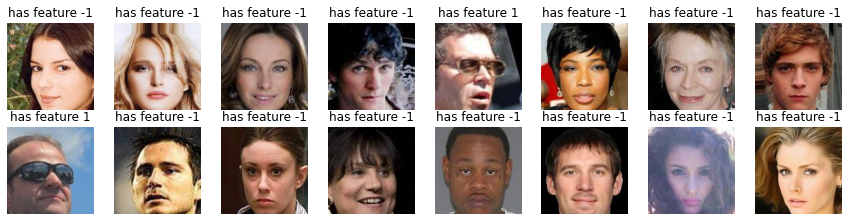

In [ ]:
x_reverse = x_test.permute(0, 2, 3, 1)
ax1 = show_grid_tensor(x_reverse, y_test, 15, 16)
ax1.show()

In [ ]:
model.eval()   
# x_test_d = x_test.
with torch.no_grad():
    encoded, z_mu , z_log_var, decoded_x = model(x_test.to(device))

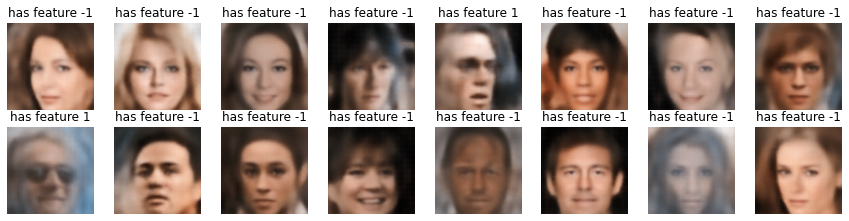

In [ ]:
x_reverse = decoded_x.to('cpu').detach().permute(0, 2, 3, 1)
ax1 = show_grid_tensor(x_reverse, y_test, 15, 16)
ax1.show()

In [ ]:
!nvidia-smi

Tue May 18 12:44:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   7898MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Compute average feature face and non feature face embds

In [ ]:
x_test.shape

torch.Size([128, 3, 128, 128])

In [ ]:
x_test[~(y_test[:, 32] == 1)].shape

torch.Size([101, 3, 128, 128])

### Get avg feature encodings

In [ ]:
def get_avg_feature_encodings(loader, model, feature_idx):
    """
    get avg encoding values for the face with the feature idx and
    for the face with out the feature idx.
    """
    model.eval()  
    x, label = next(iter(loader))
    feature_faces = label[:, feature_idx] == 1

    # print(feature_faces.sum().item())
    with torch.no_grad():
        encoded = model.encoding_fn(x.to(device))
    # encoded = gpu_encoded.to('cpu')

    feature_encodings = encoded[feature_faces]
    non_feature_encodings = encoded[~feature_faces]

    for x, label in loader:
        feature_faces = label[:, feature_idx] == 1
        # print(feature_faces.sum().item())
        with torch.no_grad():
            encoded = model.encoding_fn(x.to(device))
        # encoded = gpu_encoded.to('cpu')

        feature_encodes = encoded[feature_faces]
        non_feature_encodes = encoded[~feature_faces]
        
        feature_encodings = torch.cat((feature_encodings, feature_encodes), 
                                    axis=0)
        
        non_feature_encodings = torch.cat((non_feature_encodings,
                                         non_feature_encodes), 
                                        axis=0)

        # break

    print(feature_encodings.shape)
    print(non_feature_encodings.shape)
    return feature_encodings.mean(axis=0), non_feature_encodings.mean(axis=0)
    # return feature_encodings, non_feature_encodings

### Let's try on Eyeglasses feature
- change image's latent space so that the model decodes the latent space to image containing eyeglasses.

In [ ]:
# smile feature index = 32
# eyeglasses feature index = 15

avg_img_with_feat, avg_img_without_feat = get_avg_feature_encodings(train_loader, 
                                                     model, 
                                                     feature_idx=15)

torch.Size([11840, 200])
torch.Size([170627, 200])


In [ ]:
avg_img_with_feat.mean()
# non_smile_avg = non_smile_encodings.mean(axis=0)

tensor(0.0014, device='cuda:0')

In [ ]:
avg_img_without_feat.mean()

tensor(0.0029, device='cuda:0')

In [ ]:
diff = avg_img_with_feat - avg_img_without_feat
diff.shape

torch.Size([200])

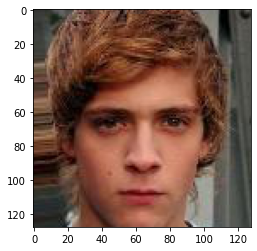

In [ ]:
# with torch.no_grad():
img_idx = 7
test_image = x_test[img_idx,:].permute(1,2,0)
plt.imshow(test_image.numpy())
plt.show()

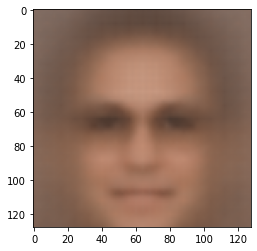

In [ ]:
with torch.no_grad():
    # dummy_face = x_test[5,:].unsqueeze(0)
    # encoded = model.encoding_fn(dummy_face.to(device))
    # new_encodes = encoded + alpha*diff
    
    decoded_avg_feature = model.decoder(avg_img_with_feat.unsqueeze(0))
    
    result = decoded_avg_feature.squeeze(0).permute(1,2,0)
    
    plt.imshow(result.to('cpu').numpy())
    plt.show()

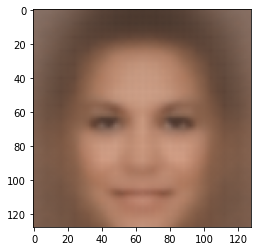

In [ ]:
with torch.no_grad():
    # dummy_face = x_test[5,:].unsqueeze(0)
    # encoded = model.encoding_fn(dummy_face.to(device))
    # new_encodes = encoded + alpha*diff
    
    decoded_avg_non_feature = model.decoder(avg_img_without_feat.unsqueeze(0))
    b
    result = decoded_avg_non_feature.squeeze(0).permute(1,2,0)
    
    plt.imshow(result.to('cpu').numpy())
    plt.show()

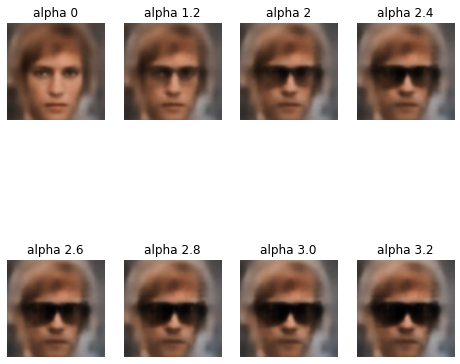

In [ ]:
alphas = [0, 1.2, 2, 2.4, 2.6, 2.8, 3.0, 3.2]

dummy_face = x_test[img_idx,:].unsqueeze(0)
diff = avg_img_with_feat - avg_img_without_feat

with torch.no_grad():
    encoded = model.encoding_fn(dummy_face.to(device))

fig = plt.figure(figsize=(8,8))

for i,alpha in enumerate(alphas):

    new_encodes = encoded + alpha*diff

    with torch.no_grad():
        decoded = model.decoder(new_encodes)
        
    result = decoded.squeeze(0).permute(1,2,0)
     
    ax = plt.subplot(2, 4, i+1)
    ax.set_title(f"alpha {alpha}") 

    plt.imshow(result.to('cpu').numpy())
    plt.axis("off")

# plt.show()